# Hydration Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]

Importing the file containing the PBAs with water molecules:

In [2]:
# with open('pba_w_APR.json', 'r') as file :
#   pba_json = file.read()

In [3]:
# print(pba_json[:1000])

In [4]:
from monty.serialization import loadfn

In [5]:
data_1 = loadfn('pba_w_APR.json')

In [6]:
# data_1[0]

In [7]:
import pymatgen as mg
from pymatgen.entries.computed_entries import ComputedEntry

In [8]:
pba_entries = []
for i in range((len(data_1))):
    #Creating pymatgen entry:
    entry = ComputedEntry(composition=data_1[i]['input']['structure'].composition,
                              energy=data_1[i]['output']['energy'],
                              parameters = {"nelect": data_1[i]['input']['parameters']['NELECT'],
                                            "hubbards": data_1[i]['input']['hubbards'],
                                            "potcar_spec": data_1[i]['input']['potcar_spec'],
                                            "is_hubbard": data_1[i]['input']['is_hubbard']})
    
#     if 'H' in entry.composition or 'O' in entry.composition: #Filtering out structures with hydrogen or oxygen
#         pba_entries.append('')
    if entry.composition.as_dict()['C'] != 24 or entry.composition.as_dict()['N'] != 24:
        #Filtering out structures that don't have 24 Cs or 24 Ns - these are also not PBAs
        pba_entries.append('')
    else:
        pba_entries.append(entry)

In [9]:
pba_entries[0]

ComputedEntry None - Ca4 Fe4 Co4 C24 N24
Energy = -476.8671
Correction = 0.0000
Parameters:
nelect = 348.0
hubbards = {}
potcar_spec = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'eb006721e214c04b3c13146e81b3a27d'}, {'titel': 'PAW_PBE Fe_pv 06Sep2000', 'hash': '5963411539032ec3298fa675a32c5e64'}, {'titel': 'PAW_PBE Co 06Sep2000', 'hash': 'b169bca4e137294d2ab3df8cbdd09083'}, {'titel': 'PAW_PBE C 08Apr2002', 'hash': 'c0a8167dbb174fe492a3db7f5006c0f8'}, {'titel': 'PAW_PBE N 08Apr2002', 'hash': 'b98fd027ddebc67da4063ff2cabbc04b'}]
is_hubbard = False
Data:

In [10]:
len(pba_entries)

3783

In [11]:
pba_h2o = []
for i in range(len(pba_entries)):
    if pba_entries[i] == '':
        continue
    if 'O' in pba_entries[i].composition.as_dict().keys():
        pba_h2o.append(pba_entries[i])
        print(i)
pba_h2o[0]

1255
1261
1287
1288
1289
1290
1292
1293
1311
1314
1319
1324
1325
1525
1532
1533
1547
1567
1568
1569
1613
1615
1618
1619
1621
1640
1642
1864
1866
1874
1875
1876
1877
1879
1880
1881
1882
1884
1885
1886
1889
1890
1891
1894
1896
1900
1901
1903
1904
1906
1907
1908
1909
1910
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134


ComputedEntry None - Mn4 Fe4 H2 C24 N24 O1
Energy = -492.5684
Correction = 0.0000
Parameters:
nelect = 332.0
hubbards = {}
potcar_spec = [{'titel': 'PAW_PBE Mn_pv 07Sep2000', 'hash': 'fa52f891f234d49bb4cb5ea96aae8f98'}, {'titel': 'PAW_PBE Fe_pv 06Sep2000', 'hash': '5963411539032ec3298fa675a32c5e64'}, {'titel': 'PAW_PBE H 15Jun2001', 'hash': 'bb43c666e3d36577264afe07669e9582'}, {'titel': 'PAW_PBE C 08Apr2002', 'hash': 'c0a8167dbb174fe492a3db7f5006c0f8'}, {'titel': 'PAW_PBE N 08Apr2002', 'hash': 'b98fd027ddebc67da4063ff2cabbc04b'}, {'titel': 'PAW_PBE O 08Apr2002', 'hash': '7a25bc5b9a5393f46600a4939d357982'}]
is_hubbard = False
Data:

In [12]:
len(pba_h2o)

329

From this, we see that there are 329 PBAs with water molecules.

In previous work, we found that the relationship between # water molecules and (Total PBA energy - energy of water molecules) is linear. We will use this to calculate the e_above_hull for hydrated molecules, which can then be used to find the stabilization effect of intercalated water.

In [13]:
from pymatgen import MPRester
mpr = MPRester(api_key='clRGHmBDgp1xt9zA')
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
mpc = MaterialsProjectCompatibility()
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
import pymatgen.analysis.local_env as localenv
crys = localenv.CrystalNN()

In [14]:
def my_crystal_nn(struct):
    '''
    Returns the A, P, and R atoms of a PBA in a list [A,P,R].
    struct is data in the form data_1[i]['input']['structure'] and must be a PBA.
    Uses pymatgen's CrystalNN method.
    '''
    A_atom_nn,P_atom_nn, R_atom_nn = '','','' #Initializing A, P, and R atoms
    for j in range(len(struct)): #Looping through all of the elements in the PBA
        atom = struct[j].as_dict()['species'][0]['element']
        
        if atom == 'C' and len(R_atom_nn)==0:
            nn_objs = crys.get_nn_info(struct, j) #getting the nearest neighbors for atom, which is the jth atom in struct
            for k in range(len(nn_objs)):
                nn = nn_objs[k]['site'].as_dict()['species'][0]['element']
                if nn != 'N':
                    R_atom_nn = nn
                    break
                    
        elif atom == 'N' and len(P_atom_nn)==0:
            nn_objs = crys.get_nn_info(struct, j) #getting the nearest neighbors for atom, which is the jth atom in struct
            for k in range(len(nn_objs)):
                nn = nn_objs[k]['site'].as_dict()['species'][0]['element']
                if nn != 'C':
                    P_atom_nn = nn
                    break
                    
    for j in struct.composition.as_dict().keys():
        if j not in [P_atom_nn,R_atom_nn,'C','N','H','O']:
            A_atom_nn = j
            break
    return [A_atom_nn,P_atom_nn,R_atom_nn]

### Main Loop
Here, we extract the total molecule energy, A/P/R atoms, # A atoms, and # water molecules for each PBA into a dataframe.

#### Actual main loop

In [15]:
pba_e_hull_df = pd.DataFrame(index=range(len(data_1)),columns=['Composition','Formula','Energy','P_atom','R_atom','n_H2O'])
for i in range(len(pba_entries)):
    try:
        if i%250 == 0:
            print(str(i) + 'th iteration') #Just to make it easier to keep track of how the algorithm is running
            
        struct=data_1[i]['input']['structure']
        pba_entry = pba_entries[i]
        if type(pba_entry) == str: #If the entry is string, then it was filtered out and we didn't create a pymatgen entry for it.
            continue
        comp = pba_entry.composition

        h2o_flag = False #Setting up a flag to tell whether this PBA is hydrated
        if 'O' in comp.as_dict().keys():
            h2o_flag = True

        comp_dict = {'structure': my_crystal_nn(struct)} #Using my custom CrystalNN function to get the A,P,R
        
        if comp_dict['structure'][0] != '': #if the A atom field is not empty:
            continue #for this analysis, we're skipping all PBAs that contain A atoms.
            #This will leave us only with the PBAs that either have H2Os or have zero A atoms and zero H2O.

        repeat_flag = False #initializing flag to indicate whether to move on to next structure because this is a repeat
        for prev in range(i): #loop through previously created entriaes to check if there are for the exact same PBA:
            if (#(comp_dict['structure'][0] == pba_e_hull_df.iloc[prev,3]) & #Checks if A atom is same
                (comp_dict['structure'][1] == pba_e_hull_df.loc[prev,'P_atom']) & #Checks P atom
                (comp_dict['structure'][2] == pba_e_hull_df.loc[prev,'R_atom']) & #Checks R atom
                #(comp.as_dict()[comp_dict['structure'][0]] == pba_e_hull_df.loc[prev,'n_A']) & #Checks # of A atoms
                (comp.as_dict()['O'] == pba_e_hull_df.loc[prev,'n_H2O'])): #checks # water molecules
                repeat_flag = True
                break
        if repeat_flag:
            continue

        #Making list of other PBAs from list pba_entries with the same composition:
        same_comps = []
        for j in range(i, len(pba_entries)):
            if type(pba_entries[j]) is str: #skip empty entries
                continue
            if pba_entries[j].composition == comp:
                same_comps.append([pba_entries[j],j])

        for k in range(len(same_comps)):
            comp_dict[same_comps[k][1]] = my_crystal_nn(data_1[same_comps[k][1]]['input']['structure'])
        #comp_dict is now a dictionary of all structures in data_1 with the same composition. The dictionary index
        #is the index of the structure in data_1, and the value is a list of the [A,P,R] atom identities.

        for k in range(len(same_comps)):
            if comp_dict[same_comps[k][1]][1] != comp_dict['structure'][1] or comp_dict[same_comps[k][1]][2] != comp_dict['structure'][2]:
                del comp_dict[same_comps[k][1]]
        #comp_dict is now a dictionary of the structures in data_1 with same composition AND same A,P,R atoms

        #We also want to delete the structures with different APR atoms dictionary from the same_comp list.
        same_comps_and_APR = []
        for k in range(len(same_comps)):
            if same_comps[k][1] in comp_dict.keys(): #check if the index for that structure is in the comp_dict keys
                same_comps_and_APR.append(same_comps[k][0])
        #same_comps_and_APR is now a list of the pymatgen entries with the same composition and APR atoms

#         #Accessing MP data for structures with the any of the same atoms:
#         comp_atoms = comp.as_dict().keys()
#         entries = mpr.get_entries_in_chemsys(comp_atoms)
#         #Adding our pbas to this list of pymatgen entries:
#         entries = entries + same_comps_and_APR

#         #Applying correction using MPRester:
#         corrected_entries = mpc.process_entries(entries)

#         #If PBA is hydrated (conatains at least one H2O), the corrected_entries step will get rid of the PBAs.
#         #Therefore, we add the pba entries back into the corrected_entries list here:
#         if h2o_flag:
#             corrected_entries = corrected_entries + same_comps_and_APR

#         #Making phase diagram:
#         phase_d = PhaseDiagram(corrected_entries)

#         #Looping through the PBA structures to find the lowest energy above hull value:
#         e_above_hull_list = []
#         for k in range(1,len(same_comps_and_APR)+1):
#             e_above_hull_list.append(phase_d.get_e_above_hull(corrected_entries[-k]))
#         e_above_hull = min(e_above_hull_list)

        #Adding the values known so far to the main df:
        pba_e_hull_df.loc[i, 'Composition'] = comp
        pba_e_hull_df.loc[i, 'Formula'] = comp.formula
        pba_e_hull_df.loc[i, 'Energy'] = pba_entry.energy
#         pba_e_hull_df.loc[i, 'e_above_hull'] = e_above_hull

        #Adding the A, P, and R atoms to main df:
#         pba_e_hull_df.loc[i, 'A_atom'] = comp_dict['structure'][0]
        pba_e_hull_df.loc[i, 'P_atom'] = comp_dict['structure'][1]
        pba_e_hull_df.loc[i, 'R_atom'] = comp_dict['structure'][2]
#         pba_e_hull_df.loc[i, 'n_A'] = comp.as_dict()[comp_dict['structure'][0]]
        if h2o_flag:
            pba_e_hull_df.loc[i, 'n_H2O'] = comp.as_dict()['O']
        else:
            pba_e_hull_df.loc[i, 'n_H2O'] = 0
        
    except:
        print('Error on ' + str(i))
        continue

0th iteration
250th iteration
500th iteration
750th iteration
1000th iteration
1250th iteration
1500th iteration
1750th iteration
2000th iteration
2250th iteration
2500th iteration
2750th iteration
3000th iteration
3250th iteration
3500th iteration
3750th iteration


In [16]:
pba_h2o = pba_e_hull_df.dropna(axis = 0, how = 'all')
pba_h2o.head()

,Composition,Formula,Energy,P_atom,R_atom,n_H2O
1255,"(Mn, Fe, H, C, N, O)",Mn4 Fe4 H2 C24 N24 O1,-492.568,Mn,Fe,1
1261,"(Mn, Fe, H, C, N, O)",Mn4 Fe4 H8 C24 N24 O4,-535.239,Mn,Fe,4
1287,"(Mn, Fe, H, C, N, O)",Mn4 Fe4 H6 C24 N24 O3,-520.961,Mn,Fe,3
1874,"(Mn, Fe, H, C, N, O)",Mn4 Fe4 H8 C24 N24 O4,-530.713,Fe,Mn,4
1875,"(Cr, H, C, N, O)",Cr8 H8 C24 N24 O4,-542.78,Cr,Cr,4


In [17]:
#Saving to file as pba_h2o.csv
pba_h2o.to_csv('pba_h2o.csv')

In [18]:
pba_h2o = pd.read_csv('pba_h2o.csv')
pba_h2o.drop('Unnamed: 0', axis = 1, inplace = True)

In [19]:
len(pba_h2o)

208

In [21]:
len(pba_h2o[pba_h2o['n_H2O'] > 0])

172

From this, we see that there are 172 unique structures that contain water molecules, plus another 36 structures that have no water molecules or A atoms.

## Analyzing hydration data
We will use the e_hull values for the given structures to extrapolate the e_hull values for each PBA at 100% hydration. Using this, we will be able to determine what fraction of the PBAs are stable at 100% hydration.

Note that others have found in previous analyses that e_hull values have a very strong linear relationship with # of water molecules, so extrapolating e_hull values at 100% hydration is a safe method of determining stability.

In [22]:
pba_h2o.head()

,Composition,Formula,Energy,P_atom,R_atom,n_H2O
0,Mn4 Fe4 H2 C24 N24 O1,Mn4 Fe4 H2 C24 N24 O1,-492.568388,Mn,Fe,1.0
1,Mn4 Fe4 H8 C24 N24 O4,Mn4 Fe4 H8 C24 N24 O4,-535.239268,Mn,Fe,4.0
2,Mn4 Fe4 H6 C24 N24 O3,Mn4 Fe4 H6 C24 N24 O3,-520.960972,Mn,Fe,3.0
3,Mn4 Fe4 H8 C24 N24 O4,Mn4 Fe4 H8 C24 N24 O4,-530.713359,Fe,Mn,4.0
4,Cr8 H8 C24 N24 O4,Cr8 H8 C24 N24 O4,-542.780128,Cr,Cr,4.0


In [23]:
p_atoms = pba_h2o['P_atom'].unique()
p_atoms

array(['Mn', 'Fe', 'Cr', 'Co', 'Zn', 'V'], dtype=object)

In [24]:
r_atoms = pba_h2o['R_atom'].unique()
r_atoms

array(['Fe', 'Mn', 'Cr', 'Os', 'Co', 'V'], dtype=object)

### Walking through the analysis for one PBA:

In [25]:
mn_fe = pba_h2o[(pba_h2o['P_atom'] == 'Mn') & (pba_h2o['R_atom'] == 'Fe')]
mn_fe = mn_fe.sort_values('n_H2O')
mn_fe

,Composition,Formula,Energy,P_atom,R_atom,n_H2O
193,Mn4 Fe4 C24 N24,Mn4 Fe4 C24 N24,-478.355188,Mn,Fe,0.0
0,Mn4 Fe4 H2 C24 N24 O1,Mn4 Fe4 H2 C24 N24 O1,-492.568388,Mn,Fe,1.0
6,Mn4 Fe4 H4 C24 N24 O2,Mn4 Fe4 H4 C24 N24 O2,-506.770166,Mn,Fe,2.0
2,Mn4 Fe4 H6 C24 N24 O3,Mn4 Fe4 H6 C24 N24 O3,-520.960972,Mn,Fe,3.0
1,Mn4 Fe4 H8 C24 N24 O4,Mn4 Fe4 H8 C24 N24 O4,-535.239268,Mn,Fe,4.0
11,Mn4 Fe4 H10 C24 N24 O5,Mn4 Fe4 H10 C24 N24 O5,-549.426479,Mn,Fe,5.0
8,Mn4 Fe4 H12 C24 N24 O6,Mn4 Fe4 H12 C24 N24 O6,-563.621715,Mn,Fe,6.0
10,Mn4 Fe4 H14 C24 N24 O7,Mn4 Fe4 H14 C24 N24 O7,-577.850115,Mn,Fe,7.0
14,Mn4 Fe4 H16 C24 N24 O8,Mn4 Fe4 H16 C24 N24 O8,-592.008134,Mn,Fe,8.0


Text(0.5,1,'Total Energy vs number of water molecules, P = Mn and R = Fe')

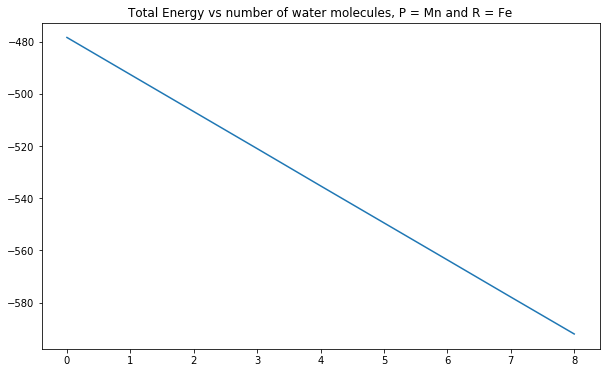

In [26]:
plt.rcParams['figure.figsize'] = [10,6]
plt.plot(mn_fe['n_H2O'],mn_fe['Energy'])
plt.title('Total Energy vs number of water molecules, P = Mn and R = Fe')

The first step to finding hydration energy is finding slope of this line:

In [42]:
slope = (mn_fe[mn_fe['n_H2O'] == 8]['Energy'].values[0] - mn_fe[mn_fe['n_H2O'] == 0]['Energy'].values[0])/8
slope #this is the hydration_energy

-14.20661818125

Next, we add in corrections for the formation energy of water and for the entropy of water:

In [43]:
h2o_formation_energy = -14.21
h2o_entropy = 0.5
corrected_slope = slope - h2o_formation_energy - h2o_entropy
corrected_slope #in eV

-0.4966181812499997

Now that we have the corrected_slope (which is the hydration energy), we can apply it to find the e_above_hull of hydrated PBAs:

In [44]:
pba_entries[2]

ComputedEntry None - Ca4 Mn4 Fe4 C24 N24
Energy = -491.4683
Correction = 0.0000
Parameters:
nelect = 364.0
hubbards = {}
potcar_spec = [{'titel': 'PAW_PBE Ca_sv 06Sep2000', 'hash': 'eb006721e214c04b3c13146e81b3a27d'}, {'titel': 'PAW_PBE Mn_pv 07Sep2000', 'hash': 'fa52f891f234d49bb4cb5ea96aae8f98'}, {'titel': 'PAW_PBE Fe_pv 06Sep2000', 'hash': '5963411539032ec3298fa675a32c5e64'}, {'titel': 'PAW_PBE C 08Apr2002', 'hash': 'c0a8167dbb174fe492a3db7f5006c0f8'}, {'titel': 'PAW_PBE N 08Apr2002', 'hash': 'b98fd027ddebc67da4063ff2cabbc04b'}]
is_hubbard = False
Data:

In [45]:
comp = pba_entries[2].composition

In [53]:
comp_atoms = comp.as_dict().keys()
comp_atoms

dict_keys(['Ca', 'Mn', 'Fe', 'C', 'N'])

In [47]:
entries = mpr.get_entries_in_chemsys(comp_atoms)
corrected_entries = mpc.process_entries(entries)
phase_d = PhaseDiagram(corrected_entries)

In [48]:
e_hull = phase_d.get_e_above_hull(pba_entries[2])
e_hull #of Ca4 Mn4 Fe4 C24 N24 PBA, uncorrected (this is in eV/atom)

0.3826480011271123

In [49]:
comp.num_atoms

60.0

In [50]:
e_hull_total = e_hull*60
e_hull_total #This is the a_above_hull of the total PBA in eV

22.958880067626737

In [51]:
e_hull_total_corrected = e_hull_total + corrected_slope*8
e_hull_total_corrected #Corrected e_above_hull for total hydrated PBA in eV

18.98593461762674

In [52]:
e_hull_corrected = e_hull_total_corrected/60
e_hull_corrected #Corrected e_above_hull in eV/atom

0.3164322436271123

Now that we know our method works for finding the e_above_hull of the hydrated PBAs, we will apply this method for all of the PBAs in the original file. 

The first step is to calculate the hydration energy for all of the P and R systems for which hydration data is available:

In [60]:
# Eventually, change this loop so it creates a df of corrected_slopes with fields for P and R atom.
e_h2o = -14.21 #energy of formation of water
s_h2o = 0.5 #entropy of formation water
e_hydration_df = pd.DataFrame(index=range(36),columns=['P_atom','R_atom','e_hydration'])
counter = 0
for p in p_atoms:
    for r in r_atoms:
        e_hydration_df.loc[counter,'P_atom'] = p
        e_hydration_df.loc[counter,'R_atom'] = r
        p_r = pba_h2o[(pba_h2o['P_atom'] == p) & (pba_h2o['R_atom'] == r)] #p_r is df of the hydrated PBAs with given p and r
        max_h2o = max(p_r['n_H2O'])
        min_h2o = min(p_r['n_H2O'])
        if (max_h2o - min_h2o) != 0:
            slope = (p_r[p_r['n_H2O'] == max_h2o]['Energy'].values[0] - p_r[p_r['n_H2O'] == min_h2o]['Energy'].values[0])/(max_h2o - min_h2o)
            corrected_slope = slope - e_h2o - s_h2o
            e_hydration_df.loc[counter,'e_hydration'] = corrected_slope
         #Systems without enough values to make a line won't have an entry in the e_hydration field
        counter += 1

In [62]:
e_hydration_df.head()

,P_atom,R_atom,e_hydration
0,Mn,Fe,-0.496618
1,Mn,Mn,-0.513344
2,Mn,Cr,-0.533875
3,Mn,Os,-0.534899
4,Mn,Co,NaN


Next, we loop through all of the PBAs in the full df (this df was the one created in notebook 02). We access the previously calculated e_above_hull from that df and apply our hydration correction method to find the e_above_hull of each PBA at 25%, 50%, and 100% hydration.

In [ ]:
#pba_e_hull_df = pd.read_csv('pba_e_hull_df.csv')
#pba_e_hull_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
for i in range(len(pba_e_hull_df)):
    